**Задача**
Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.
Наименование файлов с данными
course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

**Целевая переменная**
Credit Default - факт невыполнения кредитных обязательств
Метрика качества
F1-score (sklearn.metrics.f1_score)

**Требования к решению**
Целевая метрика
F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

Решение должно содержать
Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv
Рекомендации для файла с кодом (ipynb)
Файл должен содержать заголовки и комментарии (markdown)
Повторяющиеся операции лучше оформлять в виде функций
Не делать вывод большого количества строк таблиц (5-10 достаточно)
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
Допускается применение библиотек Python и моделей машинного обучения, 
которые были в данном курсе.

**Сроки сдачи**
1. Cдать проект нужно в течение 5 дней после окончания последнего вебинара. 
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, 
ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.
2.Примерное описание этапов выполнения курсового проекта
3.Построение модели классификации
4.Обзор обучающего датасета +
5.Обработка выбросов +
6.Обработка пропусков +
7.Анализ данных
8.Отбор признаков
9.Балансировка классов
10.Подбор моделей, получение бейзлана
11.Выбор наилучшей модели, настройка гиперпараметров
12.Проверка качества, борьба с переобучением
13.Интерпретация результатов
14.Прогнозирование на тестовом датасете

Выполнить для тестового датасета те же этапы обработки и постронияния признаков
Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
Соблюдать исходный порядок примеров из тестового датасета

Обзор данных


Описание датасета
Home Ownership - домовладение
Annual Income - годовой доход
Years in current job - количество лет на текущем месте работы
Tax Liens - налоговые обременения
Number of Open Accounts - количество открытых счетов
Years of Credit History - количество лет кредитной истории
Maximum Open Credit - наибольший открытый кредит
Number of Credit Problems - количество проблем с кредитом
Months since last delinquent - количество месяцев с последней просрочки платежа
Bankruptcies - банкротства
Purpose - цель кредита
Term - срок кредита
Current Loan Amount - текущая сумма кредита
Current Credit Balance - текущий кредитный баланс
Monthly Debt - ежемесячный долг
Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

Подключение библиотек и скриптов

In [1]:
#!pip install lightgbm
#!pip install catboost
#!pip install imblearn
#!pip install sklearn

In [2]:
import numpy as np
import pandas as pd
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import  catboost as catb
import imblearn

In [3]:
import warnings
warnings.simplefilter('ignore')

Пути к директориям и файлам

In [4]:
# input
DATASET_PATH = '../course_project/course_project_train.csv'

TEST_DATASET_PATH = '../course_project/course_project_test.csv'

# output
PREP_DATASET_PATH = '../course_project/project_train_data_prep.csv'
TRAIN_FULL_PATH = '../course_project_train_full.csv'
TRAIN_PART_PATH = '../course_project_train_part_b.csv'
TEST_PART_PATH = '../course_project_test_part.csv'

SCALER_FILE_PATH = '../scaler.pkl'
RESULT_FILE_PATH = '../MKalugina_predictions.csv'

### Загрузка данных<a class="anchor" id="load_data"></a>

In [5]:
df = pd.read_csv(DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [6]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [7]:
df.shape

(7500, 17)

In [8]:
df.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Приведение типов

### Обзор данных<a class="anchor" id="review"></a>

**Обзор целевой переменной**

In [10]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [11]:
TARGET_NAME = 'Credit Default'

**Обзор количественных признаков**

In [12]:
NUM_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts',\
                    'Years of Credit History','Maximum Open Credit',\
                    'Number of Credit Problems','Bankruptcies',\
                    'Current Loan Amount','Current Credit Balance',\
                    'Monthly Debt','Credit Score']

In [13]:

df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Поверхностный анализ данных показал, что они более-менее адекватные.

**Обзор номинативных признаков**

In [14]:
df.select_dtypes(include='object').columns

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

In [15]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [16]:
test_df = pd.read_csv(TEST_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0



**Обработка пропусков и выбросов**

In [17]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [18]:
len(test_df) - test_df.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

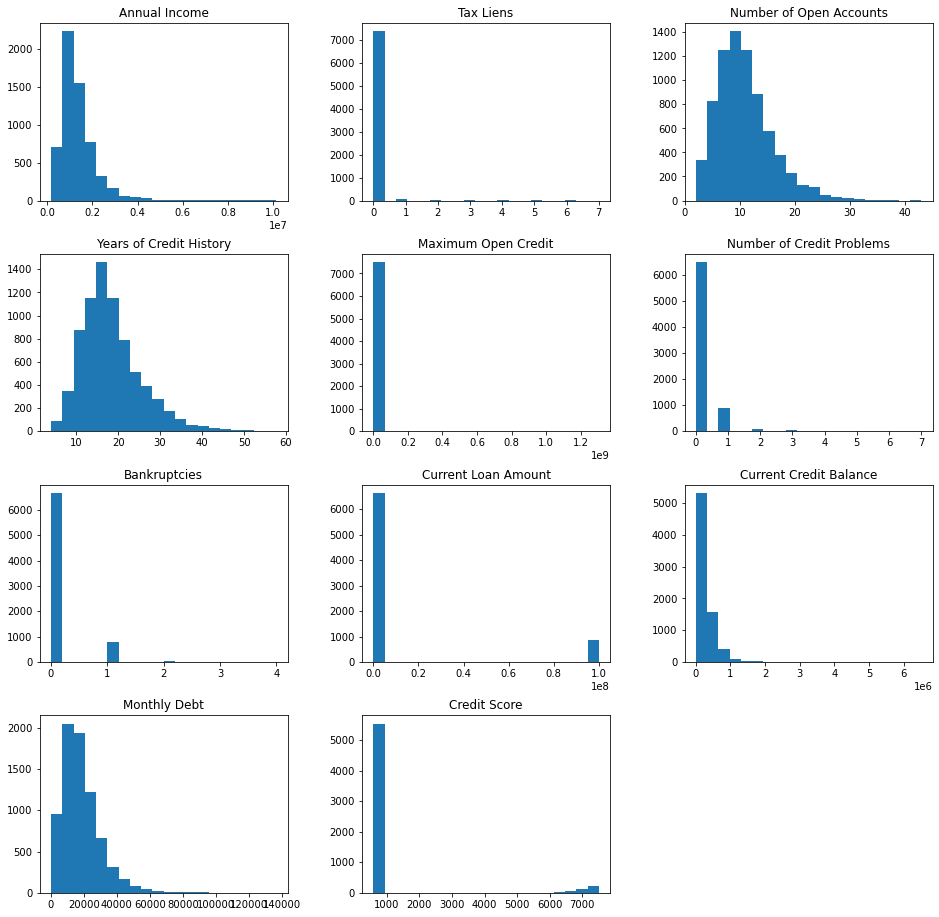

In [19]:
df[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False);

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler


#Коэффициент детерминации (R^2 — R-квадрат) 
#— это доля дисперсии зависимой переменной, объясняемая рассматриваемой моделью зависимости,
#то есть объясняющими переменными. 

def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    scaler = StandardScaler()

    data_norm = data.copy()
    data_norm[features] = scaler.fit_transform(data_norm[features])
    
    data = data_norm.copy();

    train = data[~data[target_col].isna()] # we have there some values
    train = train.dropna()
    predict_data = data[data[target_col].isna()]

   
    X = train.drop(columns=target_col)
    y = train[target_col]
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=32)
    
   # model = RandomForestRegressor(n_estimators=500,
   #                              max_depth=5,
   #                               random_state=42,
   #                               verbose=1)
    
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")
    
   
    #predict_data_new = (predict_data.drop(columns=target_col)).dropna(axis='rows').copy()


    pred = model.predict((predict_data.drop(columns=target_col)))
    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

для начала попробуем заменить все на медианы 

In [21]:
feature_name = 'Annual Income'
df[feature_name].isna().sum()

1557

In [22]:
#bill_annual_income_predictor, df_copy = imputer_rfr(df_copy, feature_name)

In [23]:
def preprocess_outlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

In [24]:
feature_name = 'Annual Income'
df_copy = preprocess_outlier(df, feature_name, threshold=7000000)
test_df_copy = test_df.copy()
test_df_copy = preprocess_outlier(test_df_copy, feature_name, threshold=7000000)
df_copy[feature_name].isna().sum()

1574

In [25]:
df["Annual Income"]. fillna(df["Annual Income"].median(),inplace = True)
test_df_copy["Annual Income"]. fillna(test_df_copy["Annual Income"].median(),inplace = True)
test_df[feature_name] = test_df_copy[feature_name]

In [26]:
df[feature_name]

0        482087.0
1       1025487.0
2        751412.0
3        805068.0
4        776264.0
          ...    
7495     402192.0
7496    1533984.0
7497    1878910.0
7498    1167436.0
7499    1167436.0
Name: Annual Income, Length: 7500, dtype: float64

In [27]:
 df["Years in current job"].fillna('10+ years',inplace = True)  

In [28]:
feature_name = 'Bankruptcies'
df = df.drop(df[df[feature_name].isna()].index)
test_df[feature_name].fillna(test_df[feature_name].median(),inplace = True)

In [29]:
df["Months since last delinquent"].fillna(df["Months since last delinquent"].median(),inplace = True)
test_df["Months since last delinquent"].fillna(test_df["Months since last delinquent"].median(),inplace = True)

In [30]:
df.loc[df["Years in current job"].isna(),"Years in current job"] = df["Years in current job"].mode()[0]
test_df.loc[test_df["Years in current job"].isna(),"Years in current job"] = test_df["Years in current job"].mode()[0]

In [31]:
test_df["Years in current job"].mode()[0]

'10+ years'

In [32]:
 df["Years in current job"].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
7495    False
7496    False
7497    False
7498    False
7499    False
Name: Years in current job, Length: 7486, dtype: bool

In [33]:
#bill_bankruptcies_predictor, df_copy = imputer_rfr(df_copy, feature_name)

Заменим этот признак "Years in current job" на числовой.


In [34]:
df["Years in current job"].loc[df["Years in current job"]=='10+ years']= '10 years'
test_df["Years in current job"].loc[test_df["Years in current job"]=='10+ years']= '10 years'


In [35]:
print(str("Years in current job") + '\n\n' + str(df["Years in current job"].value_counts()) + '\n' + '*' * 100 + '\n')

Years in current job

10 years    2702
2 years      703
3 years      620
< 1 year     557
5 years      516
1 year       501
4 years      469
6 years      425
7 years      396
8 years      338
9 years      259
Name: Years in current job, dtype: int64
****************************************************************************************************



In [36]:
df["Years in current job"].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
test_df["Years in current job"].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

In [37]:
df.loc[df["Years in current job"].astype('int32')]
test_df.loc[df["Years in current job"].astype('int32')]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
10,Own Home,941355.0,1,0.0,10.0,5.7,573650.0,0.0,30.0,0.0,debt consolidation,Short Term,327008.0,192223.0,3750.0,737.0
10,Own Home,941355.0,1,0.0,10.0,5.7,573650.0,0.0,30.0,0.0,debt consolidation,Short Term,327008.0,192223.0,3750.0,737.0
8,Rent,1175055.0,5,0.0,8.0,9.1,370524.0,0.0,30.0,0.0,major purchase,Short Term,131956.0,237747.0,10112.0,NaN
6,Home Mortgage,1233309.0,3,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,home improvements,Short Term,454388.0,292904.0,8181.0,685.0
8,Rent,1175055.0,5,0.0,8.0,9.1,370524.0,0.0,30.0,0.0,major purchase,Short Term,131956.0,237747.0,10112.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Rent,231838.0,1,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
1,Rent,231838.0,1,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
6,Home Mortgage,1233309.0,3,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,home improvements,Short Term,454388.0,292904.0,8181.0,685.0
10,Own Home,941355.0,1,0.0,10.0,5.7,573650.0,0.0,30.0,0.0,debt consolidation,Short Term,327008.0,192223.0,3750.0,737.0


In [38]:
NUM_FEATURE_NAMES.append("Years in current job")
NUM_FEATURE_NAMES


['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Years in current job']

In [39]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term']

**Credit Score

In [40]:
feature_name = 'Credit Score'
df_copy = df.copy()
test_df_copy= test_df.copy()

In [41]:
df_copy[feature_name].isna().sum()

1555

In [42]:
df_copy = df_copy.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
test_df_copy = test_df_copy.drop(columns=CAT_FEATURE_NAMES)
df_copy

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,482087.0,10,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,99999999.0,47386.0,7914.0,749.0
1,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,264968.0,394972.0,18373.0,737.0
2,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,99999999.0,308389.0,13651.0,742.0
3,805068.0,6,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,121396.0,95855.0,11338.0,694.0
4,776264.0,8,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,125840.0,93309.0,7180.0,719.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,402192.0,1,0.0,3.0,8.5,107866.0,0.0,32.0,0.0,129360.0,73492.0,1900.0,697.0
7496,1533984.0,1,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,444048.0,456399.0,12783.0,7410.0
7497,1878910.0,6,0.0,12.0,32.1,1778920.0,0.0,32.0,0.0,99999999.0,477812.0,12479.0,748.0
7498,1167436.0,10,0.0,21.0,26.5,1141250.0,0.0,32.0,0.0,615274.0,476064.0,37118.0,NaN


Так как целевая переменная сильно зависит от параметра 'Credit Score', попробуем заполнить пропуски значениями с помощью модели, их предсказывающей

In [43]:
credit_core_predictor, df_copy = imputer_rfr(df_copy, feature_name)

r2 на train: 0.01543030295990444
r2 на test: 0.012807620266881425


Создаем процедуру, которая будет подготавливать тестовый датасет к применению уже обученых моделей по замене пропусков:

In [44]:
def prepare_test_df(data, target_col):
    features = data.columns
    data = data[features]
    predict_data = data[data[target_col].isna()] 
    return predict_data

In [45]:
predict_data = prepare_test_df(test_df_copy,feature_name)

In [46]:
pred = credit_core_predictor.predict((predict_data.drop(columns=feature_name)))


In [47]:
test_df_copy.loc[test_df_copy[feature_name].isna(), feature_name] = list(pred)
df[feature_name] = df_copy[feature_name]
test_df[feature_name] = test_df_copy[feature_name]

In [48]:
 df[feature_name].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
7495    False
7496    False
7497    False
7498    False
7499    False
Name: Credit Score, Length: 7486, dtype: bool

**Monthly Debt**

In [49]:
feature_name = 'Monthly Debt'
df_copy = df.copy()
test_df_copy= test_df.copy()
df_copy = df_copy.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
test_df_copy = test_df_copy.drop(columns= CAT_FEATURE_NAMES)
df_copy = preprocess_outlier(df_copy, feature_name, threshold=90000)
test_df_copy = preprocess_outlier(test_df_copy, feature_name, threshold=90000)

df_copy[feature_name].isna().sum()

8

In [50]:
monthly_debt_predictor, df_copy = imputer_rfr(df_copy, feature_name)

r2 на train: 0.453959044269038
r2 на test: 0.43416839701030496


In [51]:
predict_data = prepare_test_df(test_df_copy,feature_name)

In [52]:
pred = credit_core_predictor.predict((predict_data.drop(columns=feature_name)))
test_df_copy.loc[test_df_copy[feature_name].isna(), feature_name] = list(pred)

In [53]:
df[feature_name] = df_copy[feature_name]
test_df[feature_name] = test_df_copy[feature_name]

**Maximum Open Credit**

In [54]:
feature_name = 'Maximum Open Credit'
df_copy = df.copy()
test_df_copy= test_df.copy()
df_copy = df_copy.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
test_df_copy = test_df_copy.drop(columns= CAT_FEATURE_NAMES)
df_copy = preprocess_outlier(df_copy, feature_name, threshold=600000000)
test_df_copy = preprocess_outlier(test_df_copy, feature_name, threshold=600000000)

maximum_open_credit_predictor, df_copy = imputer_rfr(df_copy, feature_name)
predict_data = prepare_test_df(test_df_copy, feature_name)
#pred = maximum_open_credit_predictor.predict(predict_data.drop(columns=feature_name))
#test_df_copy.loc[test_df_copy[feature_name].isna(), feature_name] = list(pred)

df[feature_name] = df_copy[feature_name]
test_df[feature_name] = test_df_copy[feature_name]

r2 на train: 0.03170308538408684
r2 на test: 0.2057488044034551


In [55]:
df_copy['Maximum Open Credit'].isna().sum()

0

In [56]:
test_df


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1175055.0,4,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,-67982.794021
1,Rent,231838.0,1,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.000000
2,Home Mortgage,1152540.0,3,0.0,10.0,13.7,204600.0,0.0,30.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.000000
3,Home Mortgage,1220313.0,10,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.000000
4,Home Mortgage,2340952.0,6,0.0,11.0,23.6,1207272.0,0.0,30.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.000000
2496,Home Mortgage,1175055.0,2,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,-122917.670396
2497,Home Mortgage,1171806.0,2,0.0,48.0,12.8,1706430.0,0.0,30.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.000000
2498,Rent,723520.0,10,0.0,14.0,28.8,945780.0,0.0,30.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.000000


Current Credit Balance

In [57]:
feature_name = 'Current Credit Balance'
df_copy = df.copy()
test_df_copy = test_df.copy() 
df_copy = df_copy.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
test_df_copy = test_df_copy.drop(columns=CAT_FEATURE_NAMES)

test_df_copy = preprocess_outlier(test_df_copy, feature_name, threshold=4000000)
df_copy = preprocess_outlier(df_copy, feature_name, threshold=4000000)
#df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=7000000)

df_copy[feature_name].isna().sum()

5

In [58]:
current_credit_balance_predictor, df_copy = imputer_rfr(df_copy, feature_name)

r2 на train: 0.3251440100179007
r2 на test: 0.3276210062193292


In [59]:
predict_data = prepare_test_df(test_df_copy,feature_name)
pred = current_credit_balance_predictor.predict((predict_data.drop(columns=feature_name)))
test_df_copy.loc[test_df_copy[feature_name].isna(), feature_name] = list(pred)

In [60]:
df[feature_name] = df_copy[feature_name]
test_df[feature_name] = test_df_copy[feature_name]

In [61]:

len(df) - df.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [62]:
len(test_df) - test_df.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

**Выделение целевой переменной и групп признаков**

In [63]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [64]:
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)
NEW_FEATURE_NAMES

Index([], dtype='object')

In [65]:
NUM_FEATURE_NAMES=[
 'Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [66]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term']

**Корреляция с базовыми признаками**

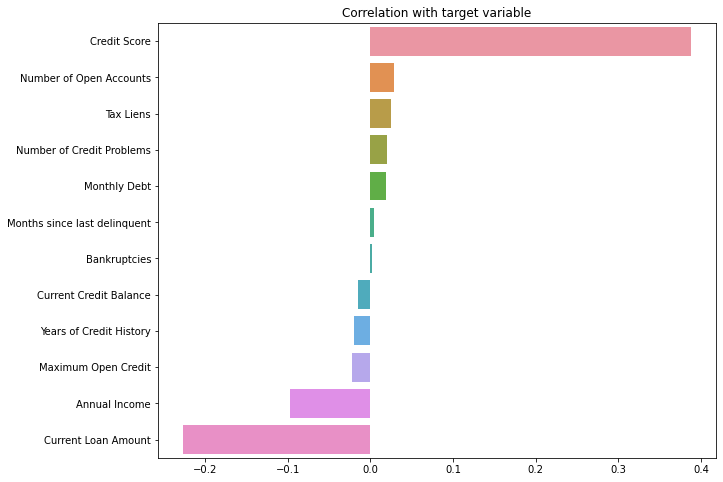

In [67]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

На этом графике видно, что признаки "Bankruptcies" и "Months since last delinquent" плохо коррелируют с целевой переменной, следовательно, попробуем исключить их при построении модели


### Анализ признакового пространства<a class="anchor" id="features_analysis"></a>

**Матрица корреляций**

In [68]:
corr_matrix = df[BASE_FEATURE_NAMES].corr()
corr_matrix

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
Annual Income,1.000000,0.050563,0.178675,0.182416,0.066796,-0.016500,-0.056675,-0.058185,0.053694,0.334136,0.519945,-0.041443
Tax Liens,0.050563,1.000000,-0.005448,0.009124,-0.003539,0.595340,0.051161,0.057360,-0.007785,-0.010047,0.028037,0.014127
Number of Open Accounts,0.178675,-0.005448,1.000000,0.144933,0.057596,-0.018085,-0.016484,-0.019130,0.002472,0.284116,0.415703,0.021674
Years of Credit History,0.182416,0.009124,0.144933,1.000000,0.044195,0.071351,0.001715,0.085699,0.009275,0.233260,0.194699,-0.017416
Maximum Open Credit,0.066796,-0.003539,0.057596,0.044195,1.000000,-0.003123,-0.003946,-0.023341,0.004490,0.165582,0.063885,-0.008967
Number of Credit Problems,-0.016500,0.595340,-0.018085,0.071351,-0.003123,1.000000,0.113387,0.730751,-0.008417,-0.130864,-0.042365,-0.018427
Months since last delinquent,-0.056675,0.051161,-0.016484,0.001715,-0.003946,0.113387,1.000000,0.109507,-0.002013,-0.026491,-0.037915,-0.002357
Bankruptcies,-0.058185,0.057360,-0.019130,0.085699,-0.023341,0.730751,0.109507,1.000000,-0.005987,-0.150739,-0.079742,-0.030413
Current Loan Amount,0.053694,-0.007785,0.002472,0.009275,0.004490,-0.008417,-0.002013,-0.005987,1.000000,0.016418,-0.008896,-0.110152
Current Credit Balance,0.334136,-0.010047,0.284116,0.233260,0.165582,-0.130864,-0.026491,-0.150739,0.016418,1.000000,0.518733,0.000785


In [69]:
corr_matrix = np.round(corr_matrix, 2)
corr_matrix

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
Annual Income,1.00,0.05,0.18,0.18,0.07,-0.02,-0.06,-0.06,0.05,0.33,0.52,-0.04
Tax Liens,0.05,1.00,-0.01,0.01,-0.00,0.60,0.05,0.06,-0.01,-0.01,0.03,0.01
Number of Open Accounts,0.18,-0.01,1.00,0.14,0.06,-0.02,-0.02,-0.02,0.00,0.28,0.42,0.02
Years of Credit History,0.18,0.01,0.14,1.00,0.04,0.07,0.00,0.09,0.01,0.23,0.19,-0.02
Maximum Open Credit,0.07,-0.00,0.06,0.04,1.00,-0.00,-0.00,-0.02,0.00,0.17,0.06,-0.01
Number of Credit Problems,-0.02,0.60,-0.02,0.07,-0.00,1.00,0.11,0.73,-0.01,-0.13,-0.04,-0.02
Months since last delinquent,-0.06,0.05,-0.02,0.00,-0.00,0.11,1.00,0.11,-0.00,-0.03,-0.04,-0.00
Bankruptcies,-0.06,0.06,-0.02,0.09,-0.02,0.73,0.11,1.00,-0.01,-0.15,-0.08,-0.03
Current Loan Amount,0.05,-0.01,0.00,0.01,0.00,-0.01,-0.00,-0.01,1.00,0.02,-0.01,-0.11
Current Credit Balance,0.33,-0.01,0.28,0.23,0.17,-0.13,-0.03,-0.15,0.02,1.00,0.52,0.00


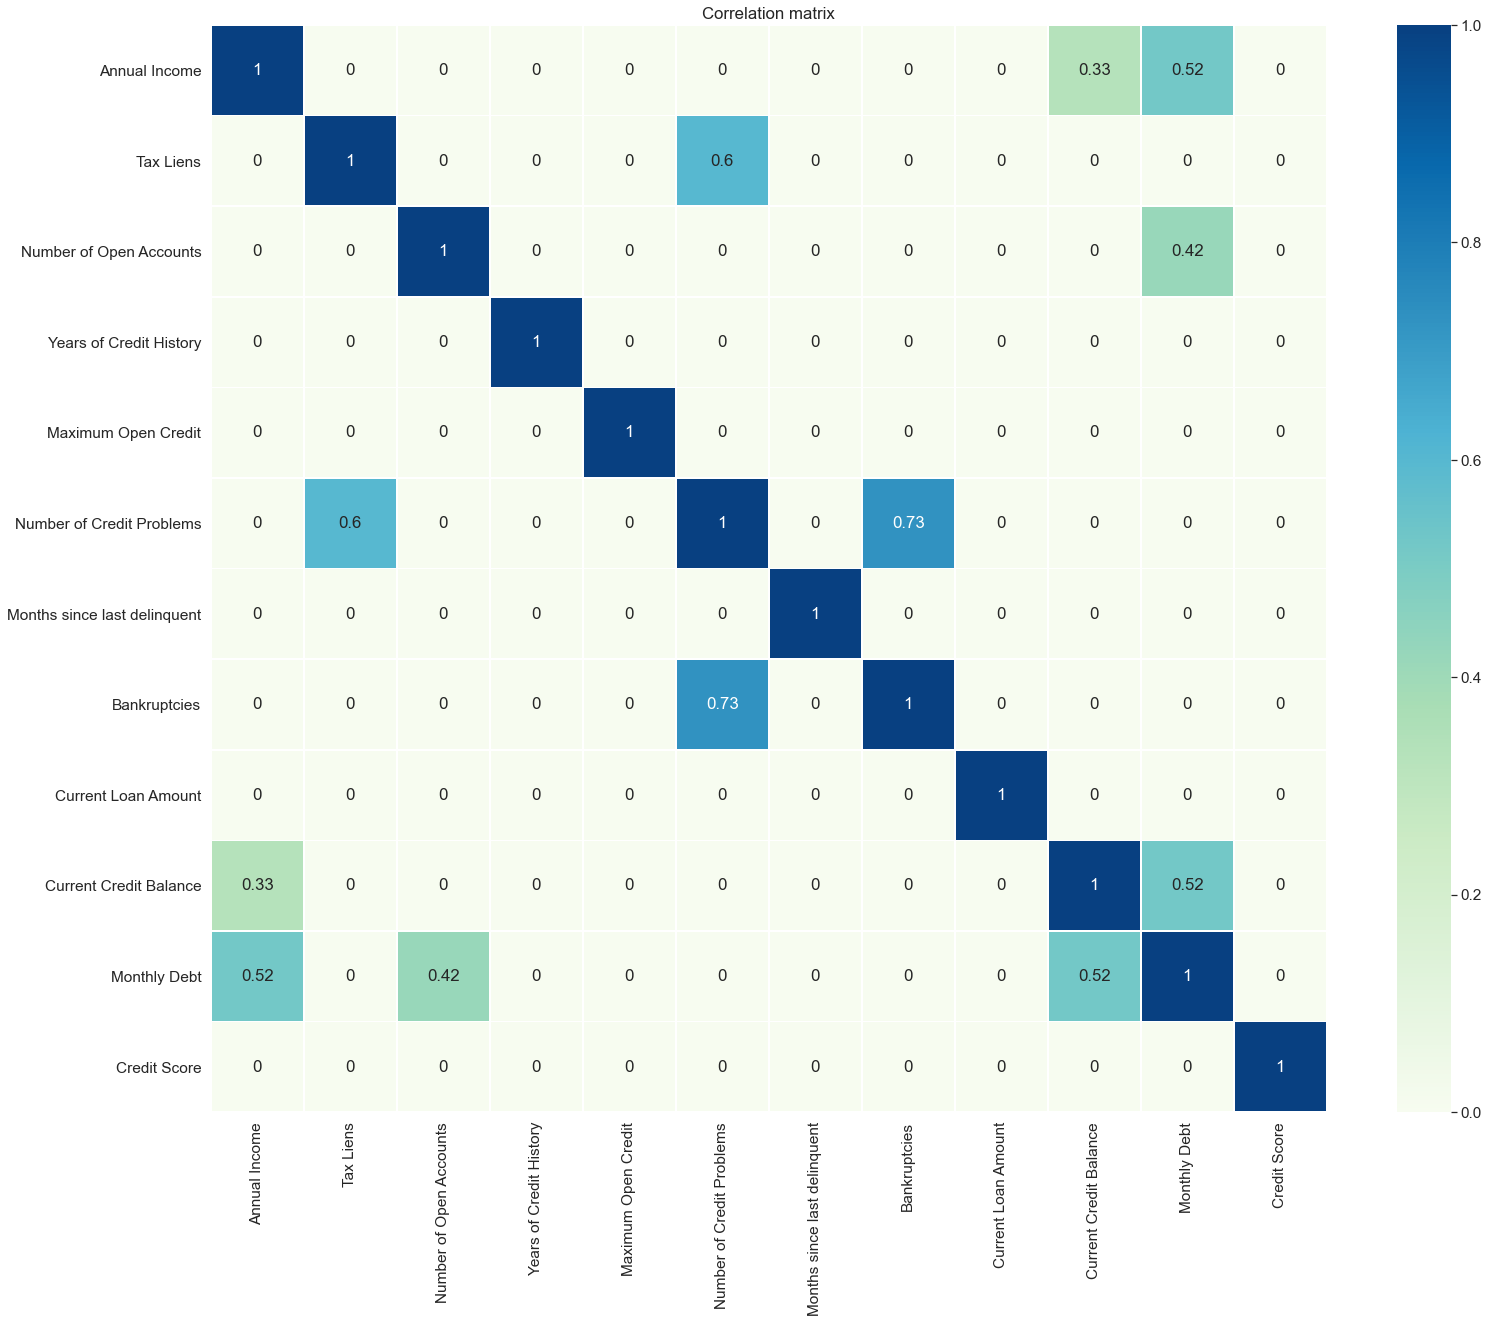

In [70]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Для эксперимента удалим из модели признаки, которые не коррелируют с целевой переменной: "Bankruptcies" и "Months since last delinquent".
И также удалим "Tax Liens", потому что она сильно коррелирует с другой переменной, и позже при построении модели мы определили, что она не оказывает весомого воздействия на модель.
    

In [71]:
df = df.drop('Bankruptcies', 1) 
df = df.drop('Months since last delinquent', 1) 
df = df.drop('Tax Liens', 1) 
df

,Home Ownership,Annual Income,Years in current job,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10,11.0,26.3,-0.015613,1.0,debt consolidation,Short Term,99999999.0,-0.812361,-0.891606,-0.249780,0
1,Own Home,1025487.0,10,15.0,15.3,0.074619,0.0,debt consolidation,Long Term,264968.0,0.366046,0.011045,-0.257280,1
2,Home Mortgage,751412.0,8,11.0,35.0,0.074747,0.0,debt consolidation,Short Term,99999999.0,0.072507,-0.396481,-0.254155,0
3,Own Home,805068.0,6,8.0,22.5,-0.113632,1.0,debt consolidation,Short Term,121396.0,-0.648038,-0.596102,-0.284155,0
4,Rent,776264.0,8,13.0,13.6,-0.070236,1.0,debt consolidation,Short Term,125840.0,-0.656670,-0.954953,-0.268530,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,1,3.0,8.5,-0.120827,0.0,other,Short Term,129360.0,-0.723854,-1.410637,-0.282280,0
7496,Home Mortgage,1533984.0,1,10.0,26.5,-0.015549,0.0,debt consolidation,Long Term,444048.0,0.574299,-0.471393,3.913335,1
7497,Rent,1878910.0,6,12.0,32.1,0.183309,0.0,buy a car,Short Term,99999999.0,0.646895,-0.497629,-0.250405,0
7498,Home Mortgage,1167436.0,10,21.0,26.5,0.067251,0.0,debt consolidation,Short Term,615274.0,0.640968,1.628809,0.099562,0


In [72]:
test_df = test_df.drop('Bankruptcies', 1) 
test_df = test_df.drop('Months since last delinquent', 1) 
test_df = test_df.drop('Tax Liens', 1) 

In [73]:
NUM_FEATURE_NAMES.remove('Bankruptcies')
NUM_FEATURE_NAMES.remove('Months since last delinquent')
NUM_FEATURE_NAMES.remove('Tax Liens')
NUM_FEATURE_NAMES

['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [74]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df,
                               test_size=0.2,
                               shuffle=True,
                               stratify=df['Credit Default'],
                               random_state=12)

In [75]:
train['Credit Default'].value_counts(normalize=True)

0    0.71827
1    0.28173
Name: Credit Default, dtype: float64

In [76]:
valid['Credit Default'].value_counts(normalize=True)

0    0.718291
1    0.281709
Name: Credit Default, dtype: float64

**Проверим распределения вещественных признаков на трейне и тесте**

Annual Income
MannwhitneyuResult(statistic=7128621.5, pvalue=0.00026099455048092827)


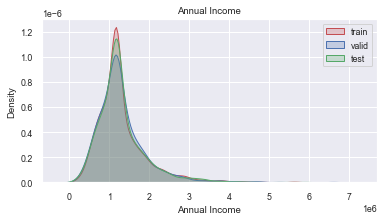

Number of Open Accounts
MannwhitneyuResult(statistic=7403116.0, pvalue=0.21251848176124088)


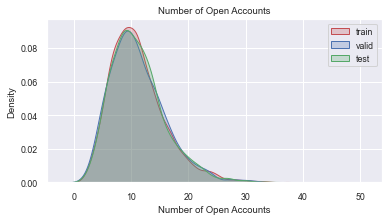

Years of Credit History
MannwhitneyuResult(statistic=7448298.5, pvalue=0.3606784933493039)


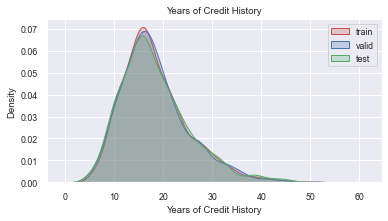

Maximum Open Credit
MannwhitneyuResult(statistic=22008.0, pvalue=0.0)


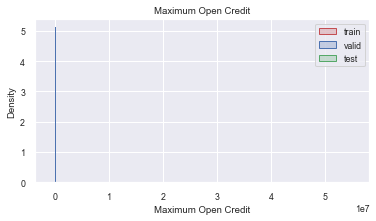

Number of Credit Problems
MannwhitneyuResult(statistic=7415918.5, pvalue=0.12911516559544312)


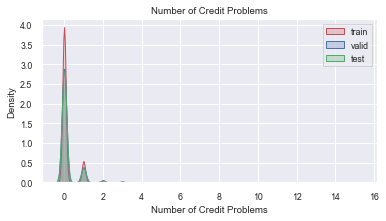

Current Loan Amount
MannwhitneyuResult(statistic=7394147.0, pvalue=0.1884567519967308)


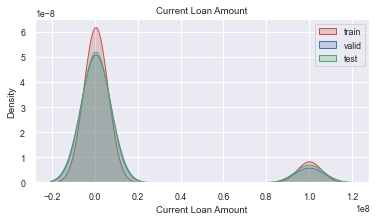

Current Credit Balance
MannwhitneyuResult(statistic=23254.0, pvalue=0.0)


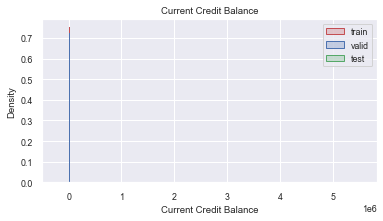

Monthly Debt
MannwhitneyuResult(statistic=11976.0, pvalue=0.0)


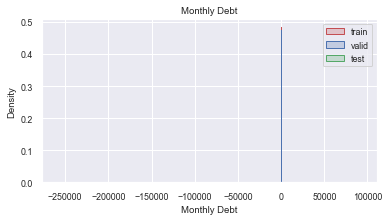

Credit Score
MannwhitneyuResult(statistic=3071844.0, pvalue=0.0)


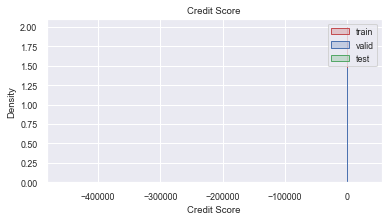

In [77]:
# p> 5% - распределения похожи
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train[col], shade=True, label='train', color='r')
    sns.kdeplot(valid[col], shade=True, label='valid', color='b')
    sns.kdeplot(test_df[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(train[col], test_df[col]))
    plt.legend()
    plt.title(col)
    plt.show()

In [78]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [79]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

**Приведение типов для модели CatBoost**

In [80]:
for colname in CAT_FEATURE_NAMES:
    train[colname] = pd.Categorical(train[colname])
    
train[CAT_FEATURE_NAMES].dtypes



Home Ownership    category
Purpose           category
Term              category
dtype: object

In [81]:
for colname in CAT_FEATURE_NAMES:
    valid[colname] = pd.Categorical(valid[colname])
    
valid[CAT_FEATURE_NAMES].dtypes

Home Ownership    category
Purpose           category
Term              category
dtype: object

**Нормализация данных**

In [82]:
scaler = StandardScaler()

train_norm = train.copy()
train_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(train_norm[NUM_FEATURE_NAMES])

train = train_norm.copy()

In [83]:

valid_norm = valid.copy()
valid_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(valid_norm[NUM_FEATURE_NAMES])
valid = valid_norm.copy()

**Сохранение модели для нормализации данных**

In [84]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [85]:
X_train = train.drop(columns=[TARGET_NAME], inplace=False)
y_train = train[TARGET_NAME]


In [86]:
y_train

7244    0
5914    0
6653    0
5171    1
3889    1
       ..
2663    1
6235    0
1919    0
5786    0
2643    0
Name: Credit Default, Length: 5988, dtype: int64

In [87]:
X_valid = valid.drop(columns=[TARGET_NAME], inplace=False)
y_valid = valid[TARGET_NAME]



**Сохранение обучающего и тестового датасетов**

In [88]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)

In [89]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
valid.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

*CatBoost*

Так как анализ важности признаков для построения модели показал, что признак Number of Credit Problems очень мало влияет на модель, попробуем удалить его

In [90]:
X_train.drop('Number of Credit Problems',1)
X_valid.drop('Number of Credit Problems',1)

,Home Ownership,Annual Income,Years in current job,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
3446,Home Mortgage,7.828173,10,0.385722,2.779256,0.678013,debt consolidation,Short Term,2.954148,1.821782,1.513058,-0.307743
2798,Home Mortgage,0.692176,10,-0.235358,0.597724,0.682257,debt consolidation,Short Term,-0.323918,1.331184,-0.049641,-0.314255
23,Own Home,-0.210761,10,1.213829,-0.493043,0.015007,debt consolidation,Short Term,-0.342946,-0.420247,-0.117588,0.057010
5050,Home Mortgage,0.867041,5,-0.649412,0.396793,-0.193126,debt consolidation,Short Term,-0.339837,0.450730,0.944106,-0.306440
5909,Home Mortgage,1.127247,10,-0.028331,-0.105534,0.328152,other,Long Term,-0.335481,0.939337,0.419329,-0.327280
...,...,...,...,...,...,...,...,...,...,...,...,...
4890,Home Mortgage,-0.503062,10,-0.442385,-0.478690,-0.186313,debt consolidation,Short Term,-0.339824,-0.426496,-0.465332,-0.309045
2343,Rent,0.577994,7,0.592749,-0.005068,-0.028882,debt consolidation,Short Term,-0.342214,0.463778,1.175683,-0.314255
7408,Rent,-0.662749,10,-0.856438,-0.363873,-0.336190,debt consolidation,Short Term,-0.343566,-0.412075,-1.121368,-0.310999
17,Home Mortgage,3.029489,3,0.592749,1.473207,0.344982,debt consolidation,Long Term,-0.332245,1.463997,2.842831,-0.375472


Получаем индексы столбцов категориальных признаков

In [91]:
CAT_FEATURES = [X_train.columns.get_loc(CAT_FEATURE_NAMES[0]),\
                X_train.columns.get_loc(CAT_FEATURE_NAMES[1]),\
                X_train.columns.get_loc(CAT_FEATURE_NAMES[2])]

In [92]:
len(df) - df.count()

Home Ownership               0
Annual Income                0
Years in current job         0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
dtype: int64

Вычисляем дисбаланс классов для балансировки во время построения модели

In [93]:
disbalance = y_train.value_counts()[0]/y_train.value_counts()[1]
disbalance

2.5494961470065203

In [94]:
model_catb = catb.CatBoostClassifier(iterations=200,\
                                     max_depth=7, silent = True, random_state=21,\
                                     cat_features=CAT_FEATURES,\
                                     eval_metric = 'F1', use_best_model = True,\
                                     #early_stopping_rounds = 20,\
                                     class_weights=[1, disbalance],
                                     reg_lambda=2)
model_catb.fit(X_train, y_train,plot=True, eval_set = (X_valid, y_valid))
#reg_lambda=0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [95]:
model_catb.best_score_

{'learn': {'Logloss': 0.4936983903992187, 'F1': 0.753976833884049},
 'validation': {'Logloss': 0.641457354869049, 'F1': 0.6584873084836185}}

In [96]:

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      4301
           1       0.53      0.50      0.51      1687

    accuracy                           0.73      5988
   macro avg       0.67      0.66      0.66      5988
weighted avg       0.73      0.73      0.73      5988

TEST

              precision    recall  f1-score   support

           0       0.83      0.78      0.81      1076
           1       0.52      0.60      0.56       422

    accuracy                           0.73      1498
   macro avg       0.68      0.69      0.68      1498
weighted avg       0.74      0.73      0.74      1498

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               843  233
1               170  252


In [97]:
test_df

,Home Ownership,Annual Income,Years in current job,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1175055.0,4,9.0,12.5,220968.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,-67982.794021
1,Rent,231838.0,1,6.0,32.7,55946.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.000000
2,Home Mortgage,1152540.0,3,10.0,13.7,204600.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.000000
3,Home Mortgage,1220313.0,10,16.0,17.0,456302.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.000000
4,Home Mortgage,2340952.0,6,11.0,23.6,1207272.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10,14.0,29.1,559152.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.000000
2496,Home Mortgage,1175055.0,2,15.0,17.0,1737780.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,-122917.670396
2497,Home Mortgage,1171806.0,2,48.0,12.8,1706430.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.000000
2498,Rent,723520.0,10,14.0,28.8,945780.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.000000


In [98]:
y_test_pred = model_catb.predict(test_df)

In [99]:
y_test_pred 

array([0, 0, 0, ..., 0, 0, 0])

In [100]:

submit = pd.read_csv(TEST_DATASET_PATH)
submit.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [101]:
#submit_new = pd.DataFrame(submit, columns=['Id'])
submit['Credit Default'] = y_test_pred

submit.to_csv(RESULT_FILE_PATH, index=False, encoding='utf-8')
submit

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN,0
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0,0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0,0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN,0
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0,0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0,0


Подбор гиперпараметров

In [102]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20, 
     'reg_lambda':2
}
model_catb = catb.CatBoostClassifier(**frozen_params)

In [103]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)


In [104]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5832143654
bestIteration = 27

0:	loss: 0.5832144	best: 0.5832144 (0)	total: 352ms	remaining: 8.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5832143654
bestIteration = 27

1:	loss: 0.5832144	best: 0.5832144 (0)	total: 682ms	remaining: 7.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.581463687
bestIteration = 42

2:	loss: 0.5814637	best: 0.5832144 (0)	total: 1.23s	remaining: 8.59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.581463687
bestIteration = 42

3:	loss: 0.5814637	best: 0.5832144 (0)	total: 1.82s	remaining: 9.08s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.581463687
bestIteration = 42

4:	loss: 0.5814637	best: 0.5832144 (0)	total: 2.37s	remaining: 9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.581463687
bestIteration = 42

5:	loss: 0.5814637	best: 0.5832144 (0)	total: 2.8s	remaining: 8.41s
St

In [105]:
grid_search

{'params': {'depth': 5, 'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20],
              'test-F1-mean': [0.6242505451498276,
               0.6218791399106148,
               0.6085086930175185,
               0.6206850947464121,
               0.6211987037474038,
               0.6180054079471479,
               0.6166892990732201,
               0.6142623406814848,
               0.6052876320439725,
               0.6009537410168956,
               0.6028923802411131,
               0.6053457463938593,
               0.6078422085487697,
               0.6113458869613444,
             

In [106]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.624251,0.010202,0.627860,0.006460,0.681114,0.001456,0.681095,0.000230
1,1,0.621879,0.014102,0.623881,0.006994,0.669669,0.002377,0.669421,0.000559
4,4,0.621199,0.021707,0.620816,0.003442,0.644001,0.005409,0.643077,0.000283
3,3,0.620685,0.023347,0.621724,0.008742,0.651793,0.004777,0.651138,0.000797
5,5,0.618005,0.012210,0.622586,0.001162,0.636221,0.005978,0.635120,0.000138


In [107]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

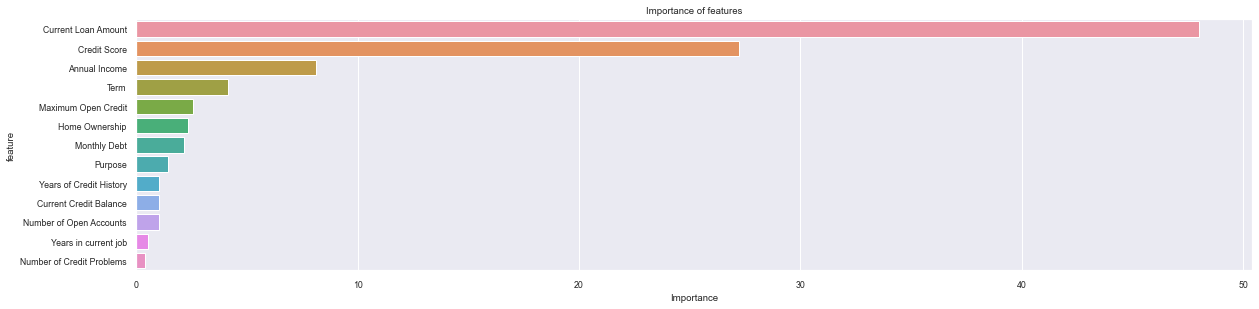

In [108]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=23)

In [109]:
y_test_pred = model_catb.predict(test_df)